# Foco da Analise, primeiras impressões


Realizar uma clusterização com as seguintes colunas, para compreender quais são os perfis de carros que mais alugados por cada perfil de cliente: 
        'Tipo do cliente', 'Tipo de carro alugado','Quilometragem do carro','Qualidade do carro', 'Tipo de transmissão', 'Combustível', 'Idade do carro', 'Marca do carro'

Realizar com as seguintes colunas, para conseguir uma métrica de receita:
        'Tempo de aluguel', 'Data de início do aluguel', 'Valor do contrato do aluguel','Estado de pagamento','Método de pagamento', 'Contrato cancelado antes do prazo', 'Desconto aplicado no contrato', 'Pagamentos atrasados'

Realizar com as seguintes colunas, para conseguiur encontrar o perfil dos clientes mais valiosos:
        'Tipo do cliente', 'Histórico de contratos anteriores', 'Valor do contrato do aluguel', 'Tempo de aluguel'

Analise do porque ocorrem cancelamentos das compras:
        'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)'

Apagar coluna coerente, True para todas as linhas

In [492]:
# Importação das bibliotecas para analise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from cmdstanpy import CmdStanModel


In [493]:
db_alugueis = pd.read_csv('historico_alugueis.csv')

In [494]:
display(db_alugueis.columns)


Index(['ID do cliente', 'Tipo do cliente', 'Tipo de carro alugado',
       'Tempo de aluguel', 'Data de início do aluguel',
       'Data final do aluguel', 'Valor do contrato do aluguel',
       'Estado de pagamento', 'Método de pagamento', 'Quilometragem do carro',
       'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
       'Idade do carro', 'Marca do carro', 'Cor do carro',
       'Interações com o suporte', 'Tipo do problema para contactar o suporte',
       'Satisfação do cliente', 'Contrato cancelado antes do prazo',
       'Motivo do cancelamento', 'Desconto aplicado no contrato',
       'Histórico de contratos anteriores', 'Pagamentos atrasados'],
      dtype='object')

---------------------------------------------------------

# Limpeza dos dados de cada coluna

In [495]:
# Entendentendo os dados
display(db_alugueis.dtypes)

ID do cliente                                float64
Tipo do cliente                               object
Tipo de carro alugado                         object
Tempo de aluguel                             float64
Data de início do aluguel                     object
Data final do aluguel                         object
Valor do contrato do aluguel                  object
Estado de pagamento                           object
Método de pagamento                           object
Quilometragem do carro                       float64
Qualidade do carro                            object
Tipo de transmissão                           object
Combustível                                   object
Idade do carro                               float64
Marca do carro                                object
Cor do carro                                  object
Interações com o suporte                     float64
Tipo do problema para contactar o suporte     object
Satisfação do cliente                        f

In [496]:
#retirnando linhas que contem todos os valores nulos e linhas duplicadas
db_alugueis.dropna(how='all', inplace=True)
db_alugueis = db_alugueis.drop_duplicates()

# Apagando colunas que não serão utilizadas
db_alugueis.drop(columns=['Interações com o suporte'], inplace=True)


In [497]:
# Passando por cada coluna para tratar ela da melhor forma
# Utilizando primeiro o display com unique para entender os valores unicos de cada coluna
# Em seguida realizando o tratamento de acordo com o que foi observado
db_alugueis = db_alugueis.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
db_alugueis = db_alugueis.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

# Tratando a coluna 'ID do aluguel'
db_alugueis['ID do cliente'] = db_alugueis['ID do cliente'].astype(int)

# Tratando a coluna 'tipo de carro alugado'

# Tratando a coluna 'Tempo de aluguel'
db_alugueis['Tempo de aluguel'] = db_alugueis['Tempo de aluguel'].astype(int)

#Data de inicio
import re

# Function to convert months in Portuguese-English mix to standard format
# Modify the function to handle non-string (NaN) values safely

def convert_portuguese_date_format(date_str):
    if isinstance(date_str, str):
        # Mapping English month names to their corresponding numbers
        months_mapping = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
            'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
            'november': '11', 'december': '12'
        }

        # Pattern to match the format '6 de january de 2022'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                return f'{day}/{month_num}/{year}'
    return date_str  # Return as is if it's not a match or not a string

db_alugueis['Data de início do aluguel'] = db_alugueis['Data de início do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data de início do aluguel'] = pd.to_datetime(db_alugueis['Data de início do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Data final do aluguel'    
db_alugueis['Data final do aluguel'] = db_alugueis['Data final do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data final do aluguel'] = pd.to_datetime(db_alugueis['Data final do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Valor do contrato do aluguel'
def clean_valor_do_contrato(value):
    if isinstance(value, str):
        value = value.lower()
        value = value.replace('r$', '').replace('.', '').replace(',', '.').strip()
    return float(value) if value else None

db_alugueis['Valor do contrato do aluguel'] = db_alugueis['Valor do contrato do aluguel'].apply(clean_valor_do_contrato)

#Tratando a coluna Idade do carro
db_alugueis['Idade do carro'] = db_alugueis['Idade do carro'].astype(int)

# Tratando a coluna Satisfação do cliente
db_alugueis['Satisfação do cliente'] = db_alugueis['Satisfação do cliente'].astype(int)

# Tratando Desconto aplicado no contrato
db_alugueis['Desconto aplicado no contrato'] = db_alugueis['Desconto aplicado no contrato'].apply(clean_valor_do_contrato)
                              


---------------------------------------------------------

# Analise Exploratoria

In [498]:
# Obtendo dados estatísticos basicos
db_alugueis.describe().round(2)


,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Satisfação do cliente,Desconto aplicado no contrato
count,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00
mean,41730.08,6.69,39508.35,66170.39,3.71,4.05,9.99
std,24102.83,6.93,46738.96,40096.19,1.88,1.16,6.06
min,1.00,1.00,2000.00,15000.00,1.00,1.00,0.00
25%,20903.00,1.00,7308.00,32356.00,2.00,3.00,5.00
50%,41604.50,3.00,20040.00,49959.50,4.00,5.00,10.00
75%,62617.00,12.00,54564.00,99884.25,5.00,5.00,15.00
max,83649.00,24.00,240000.00,149998.00,7.00,5.00,20.00


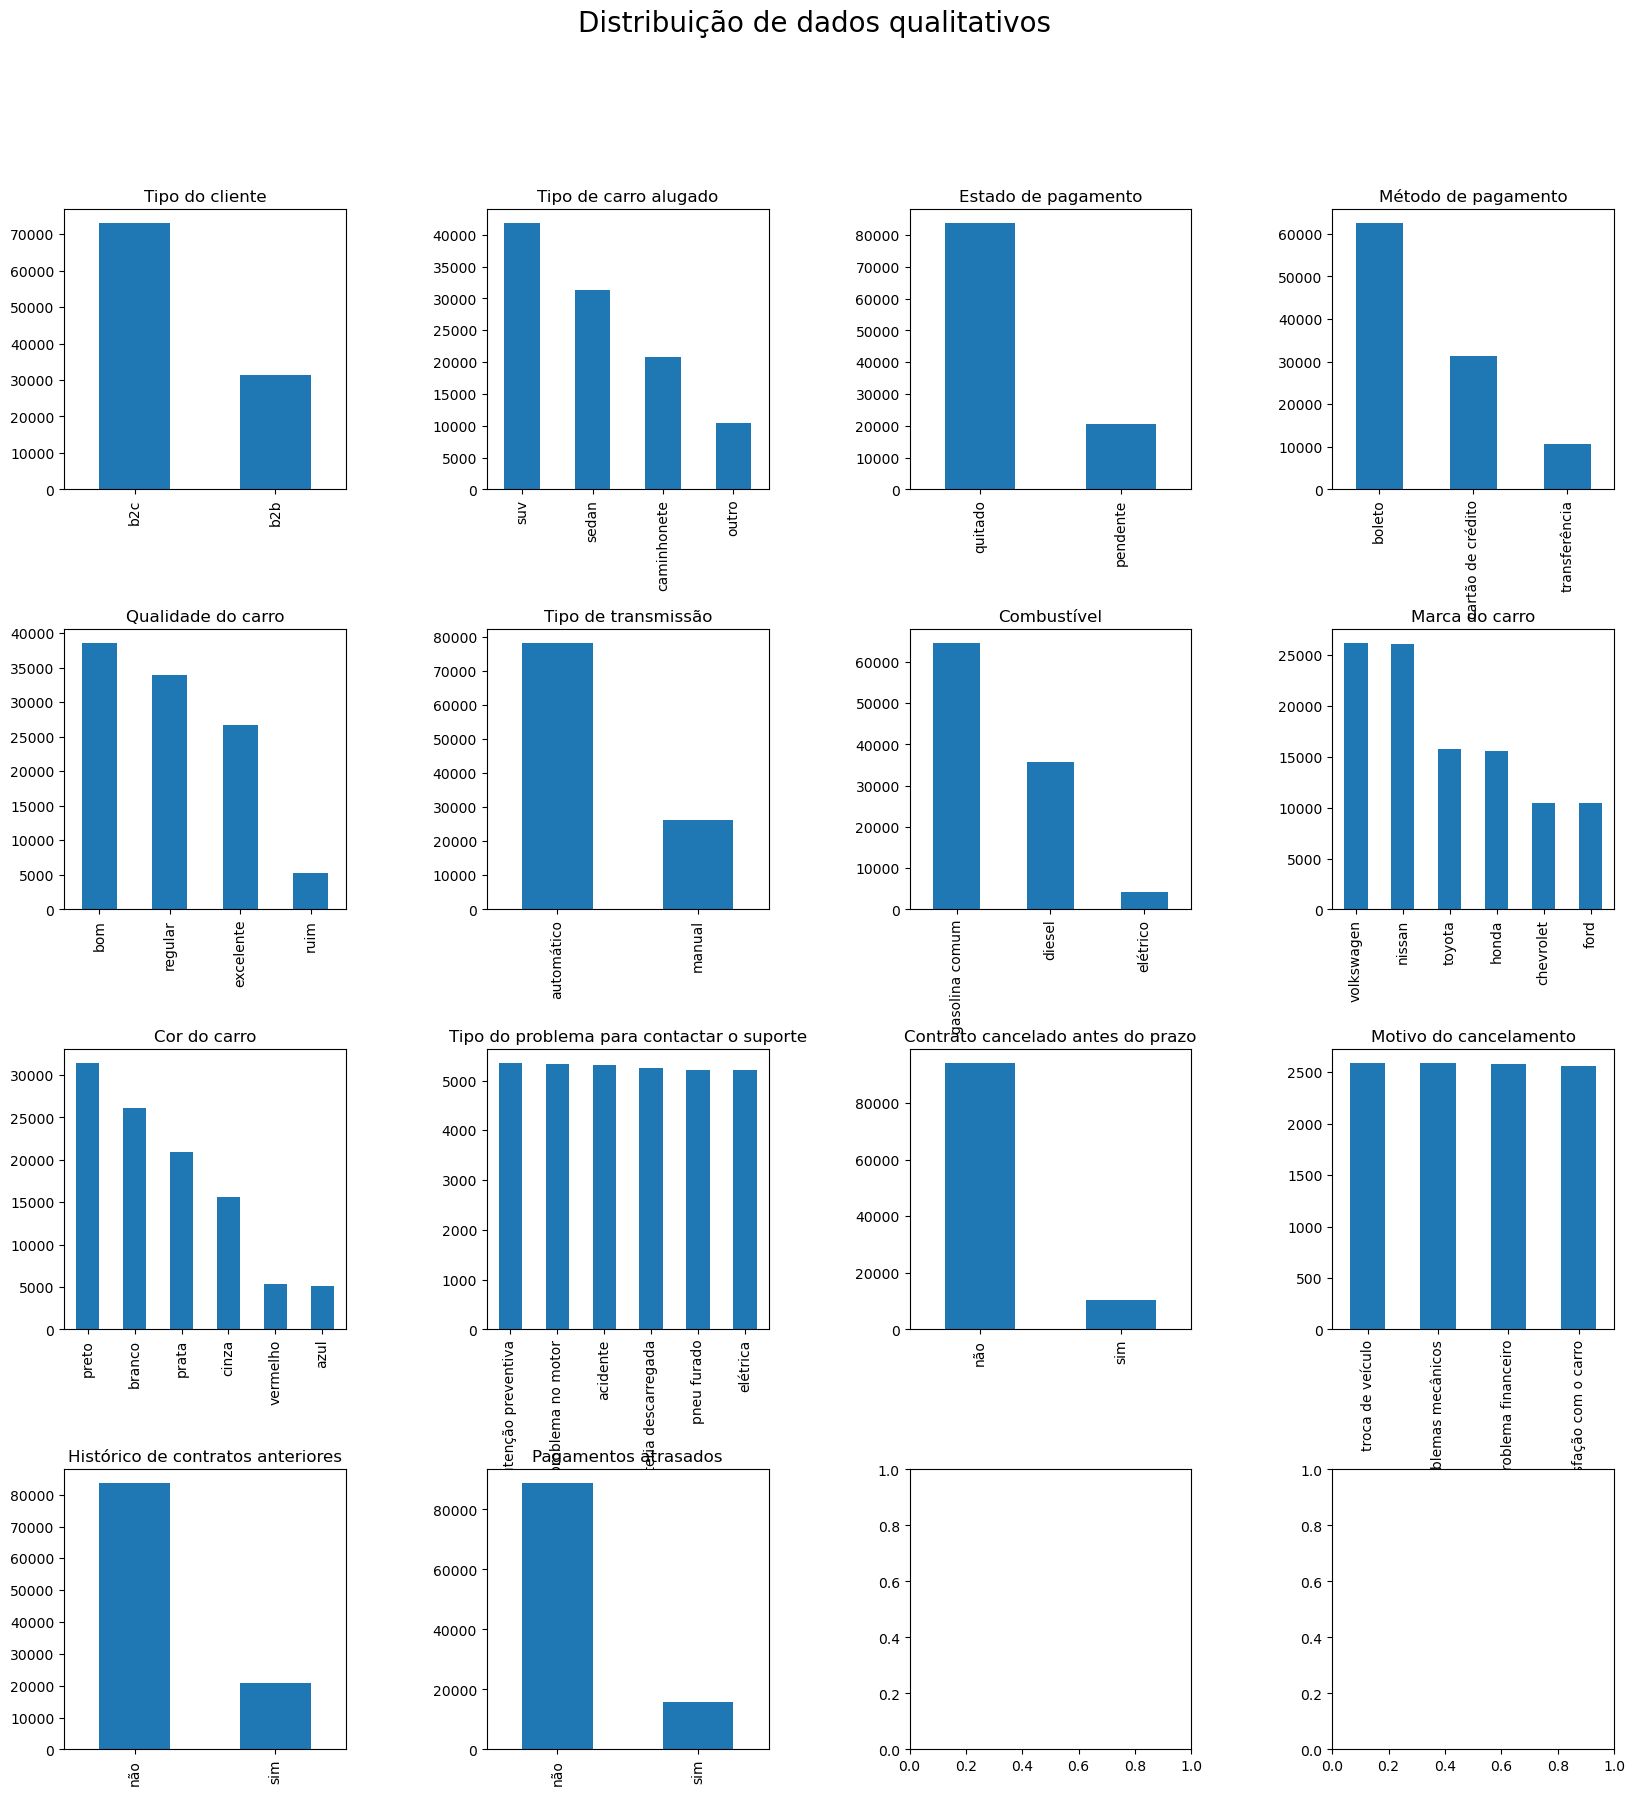

In [499]:
# Lista das colunas qualitativas do db_alugueis que podem agregar em analises futuras
colunas_qualitativas = ['Tipo do cliente', 'Tipo de carro alugado','Estado de pagamento', 'Método de pagamento',
                         'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
                         'Marca do carro', 'Cor do carro','Tipo do problema para contactar o suporte',
                         'Contrato cancelado antes do prazo', 'Motivo do cancelamento','Histórico de contratos anteriores', 'Pagamentos atrasados']

# Realizar um plot de barras para cada coluna qualitativa, usando subplot para poder vizualizar todas juntas
# Quero adicionar espaços entre os gráficos, então vou usar o método subplots_adjust() para ajustar o espaço entre eles
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)
for col, ax in zip(colunas_qualitativas, axs.ravel()):
    db_alugueis[col].value_counts().plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()


### Conclusões iniciais com pequena análise

- O maior perfil de cliente é o B2C, entretanto 30% é B2B, o que pode ser um bom nicho de mercado para explorar, pois são cliente que tem maior potencial de renovação de contrato, e maior valor de contrato por um tempo maior.

- O Histórico de contratos anteriores é um fator que influencia muito no valor do contrato, devido aos descontos dados, mas mesmo assim somente cerca de 20% dos clientes tem histórico de contratos anteriores. Vale a pena Analisar quantos ids de clientes se repetem para entender se o histórico de contratos anteriores é um fator que influencia na renovação de contrato. **Ponto importante de ser analisado, pois a retenção de clientes é mais barata que a aquisição de novos clientes, e no momento não está muito alta**

- A média de Satisfação do cliente é de 4.05 o que é um bom indicativo, ainda maais com um desvio padrão de 1.16, o que indica que a maioria das avaliações estão entre 3 e 5 (a cima da média), logo fica o questionamento: Por que poucos cliente renovaram? a Empresa é muito nova para ter tido muitas renovações? ou a empresa não está conseguindo fidelizar os clientes por algum outro motivo sem ser a satisfacao do cliente?

- A média de valor do contrato é de 40mil reais, entretanto como o tempo varia nos contratos é interessante analisar o preço por mês.

- A idade média dos carros é de 3.71, entretanto a quilometragem média é de 66000 Km

- Os carros mais alugados são carros modernos, com cores neutras, com cambio automatico, normalmente SUV ou sedans, com combustivel a gasolina, e com qualidade de carro acima de regular.

- As marcas principais são Volkswagen e Nissan

In [500]:
# Para aprofundar um pouco mais nossa analise, vamos separar o database em dois, um com o tipo de cliente B2B e outro com o tipo de cliente B2C
db_alugueis_b2b = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2b']
db_alugueis_b2c = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2c']


### Mesma Analise, pórem separando por tipo de cliente

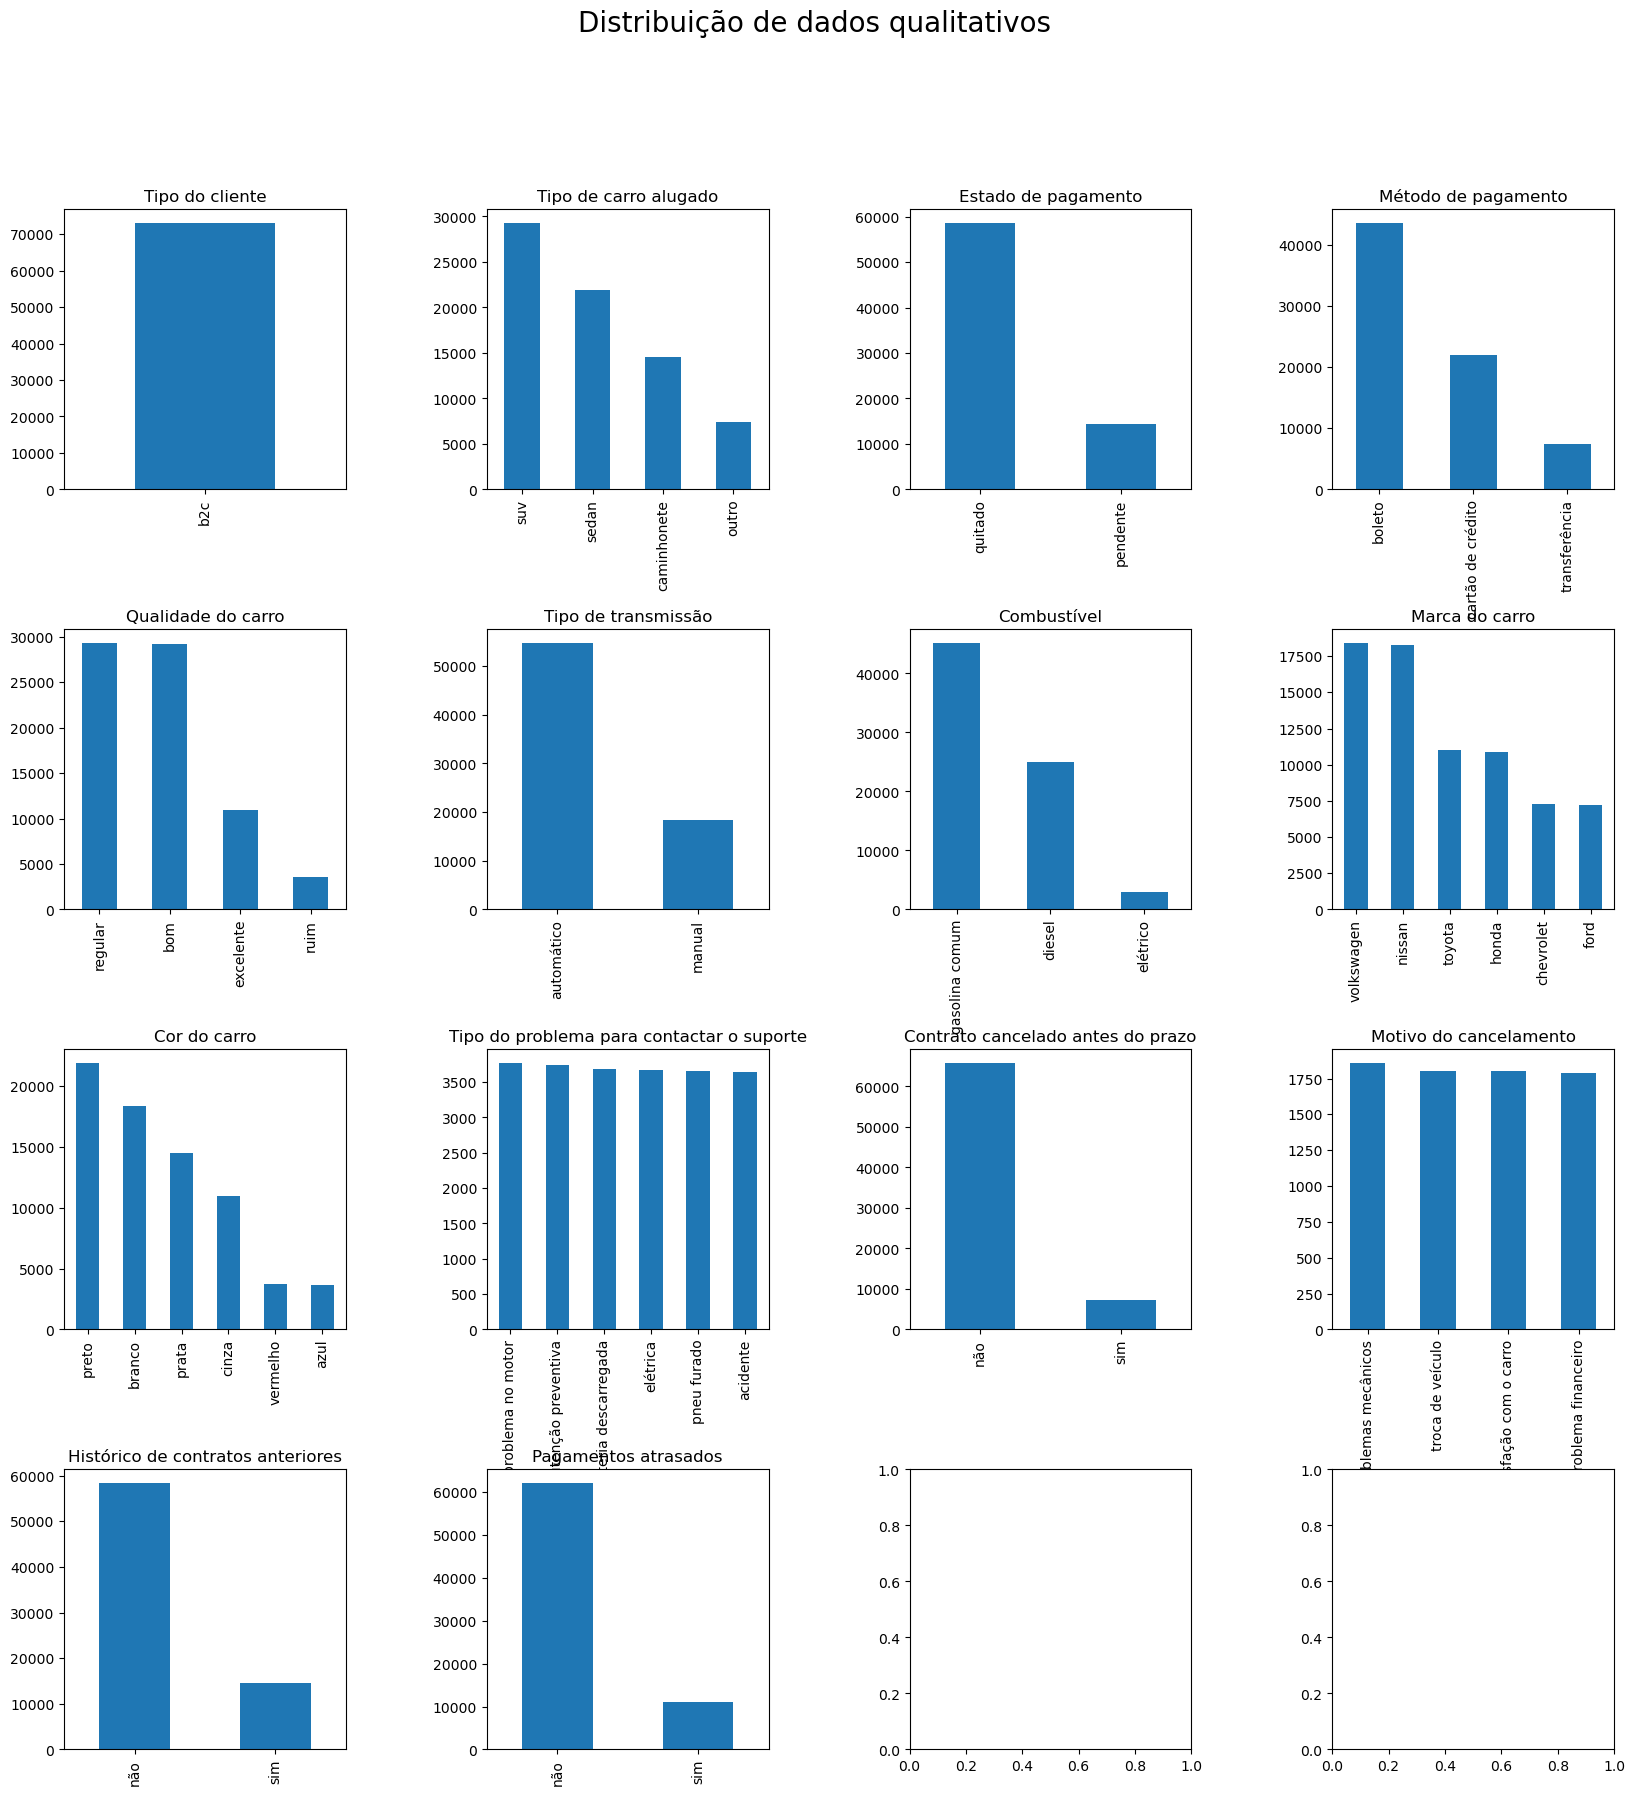

,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Satisfação do cliente,Desconto aplicado no contrato
count,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00
mean,41737.44,2.59,15305.59,66169.63,3.71,4.06,9.99
std,24108.98,1.90,13455.28,40062.86,1.87,1.15,6.07
min,1.00,1.00,2000.00,15000.00,1.00,1.00,0.00
25%,20885.75,1.00,5812.00,32411.00,2.00,3.00,5.00
50%,41639.00,1.00,9281.00,49969.50,4.00,5.00,10.00
75%,62616.75,3.00,22116.00,99916.25,5.00,5.00,15.00
max,83649.00,6.00,60000.00,149998.00,7.00,5.00,20.00


In [501]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)

for col, ax in zip(colunas_qualitativas, axs.ravel()):
    db_alugueis_b2c[col].value_counts().plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()

db_alugueis_b2c.describe().round(2)

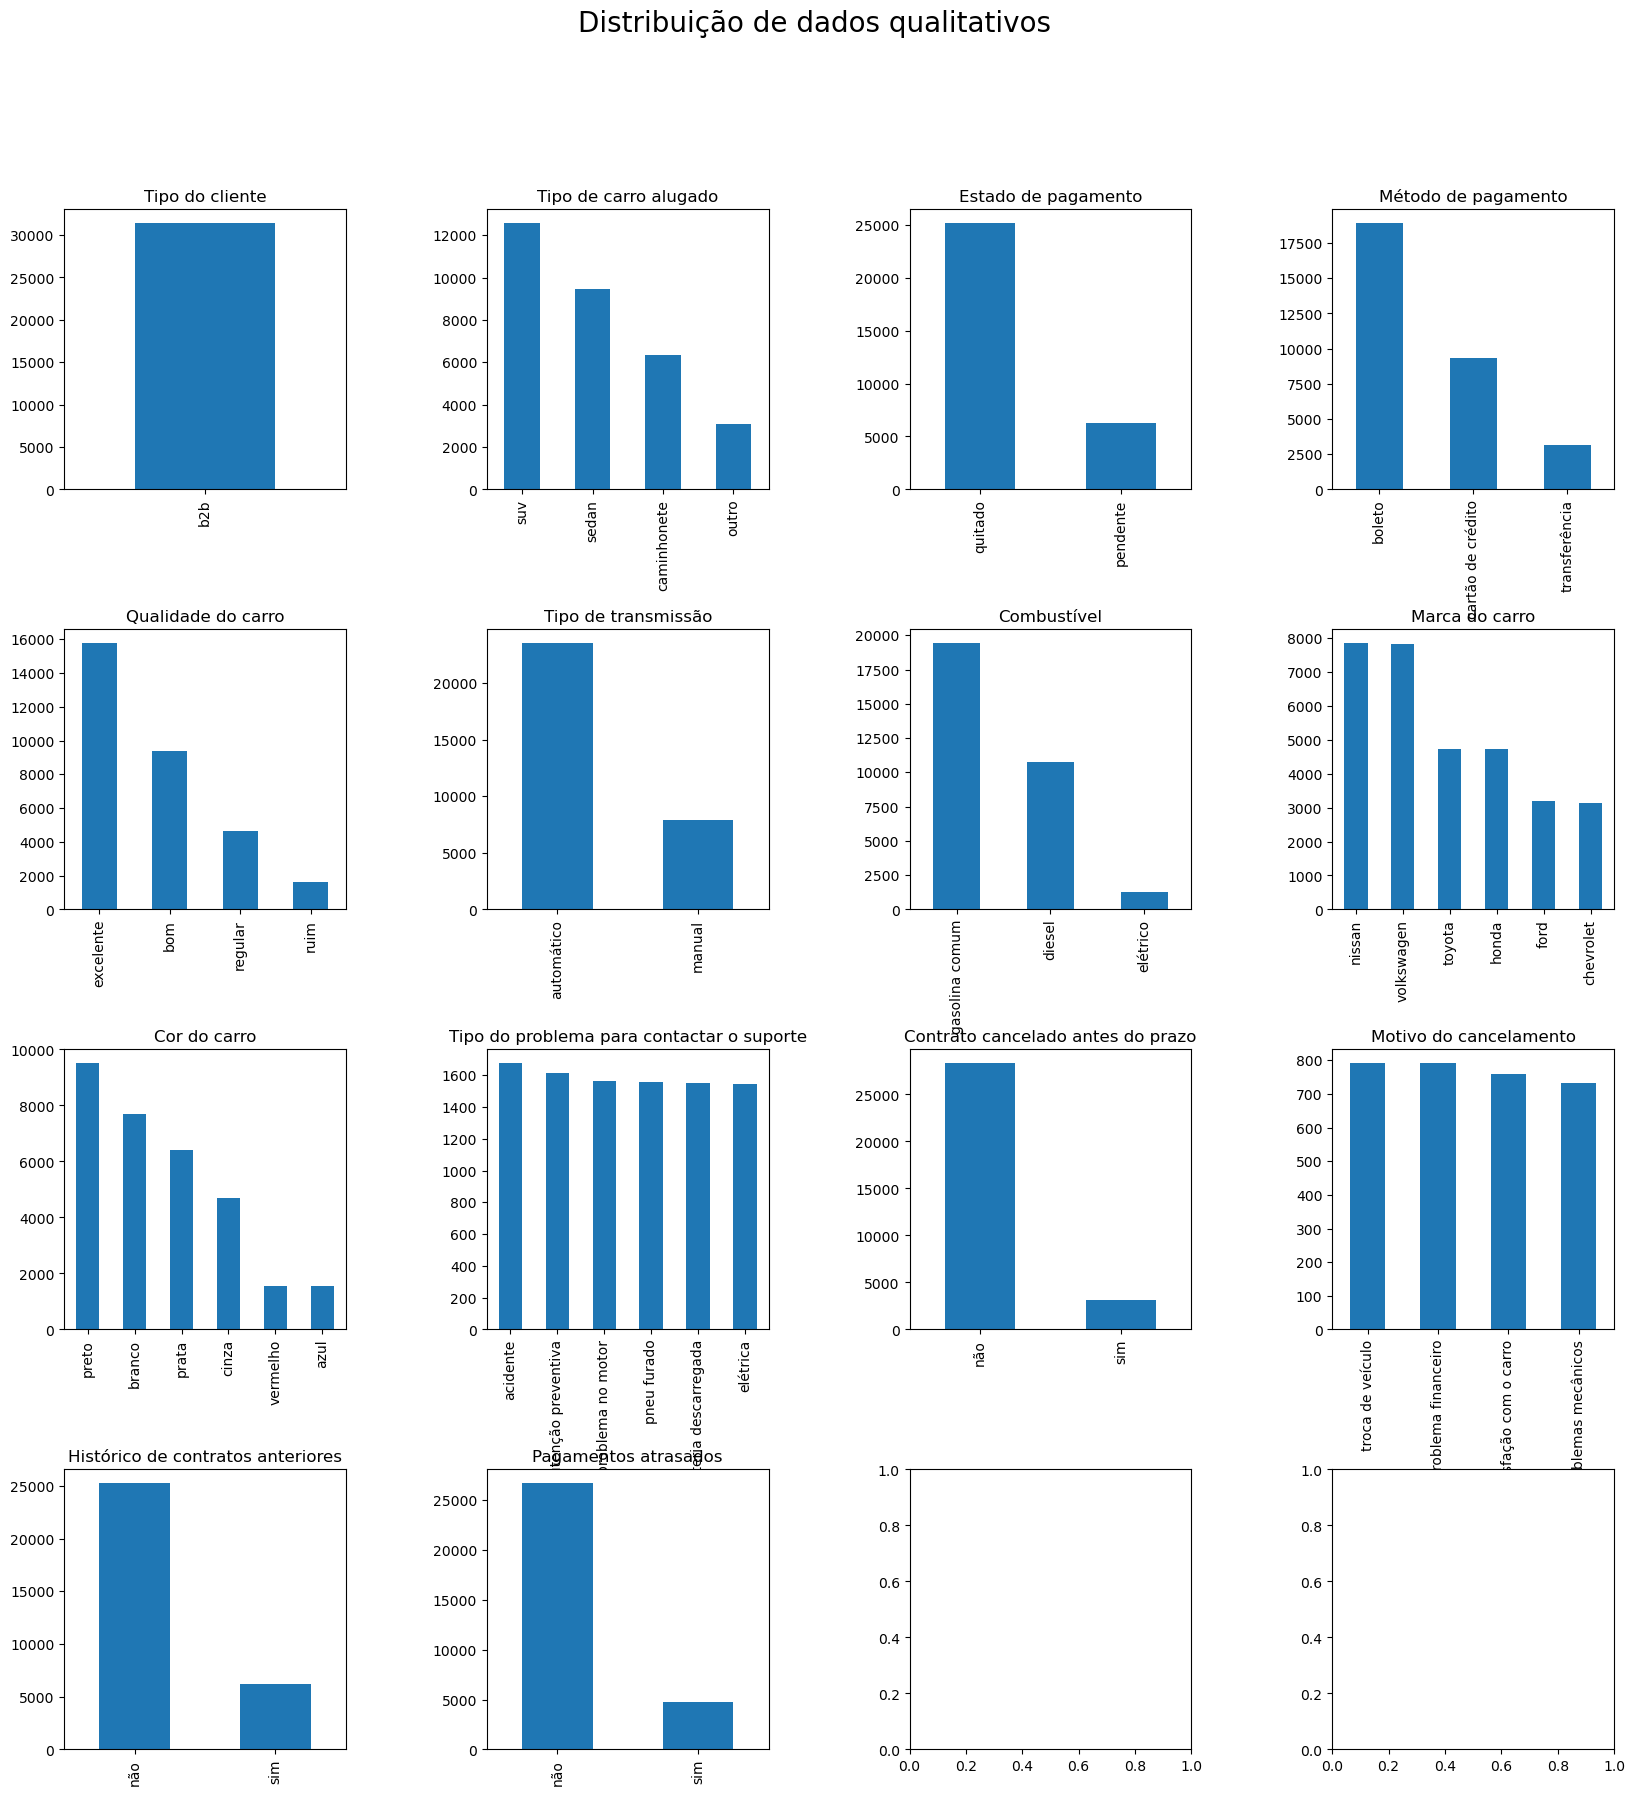

,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Satisfação do cliente,Desconto aplicado no contrato
count,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00
mean,41712.95,16.20,95769.07,66172.15,3.70,4.04,10.00
std,24088.89,4.68,48112.65,40174.19,1.88,1.16,6.04
min,3.00,12.00,24000.00,15005.00,1.00,1.00,0.00
25%,20960.00,12.00,58128.00,32231.75,2.00,3.00,5.00
50%,41508.50,18.00,88026.00,49937.00,4.00,4.00,10.00
75%,62617.00,18.00,119091.00,99819.50,5.00,5.00,15.00
max,83649.00,24.00,240000.00,149998.00,7.00,5.00,20.00


In [502]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)

for col, ax in zip(colunas_qualitativas, axs.ravel()):
    db_alugueis_b2b[col].value_counts().plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()

db_alugueis_b2b.describe().round(2)


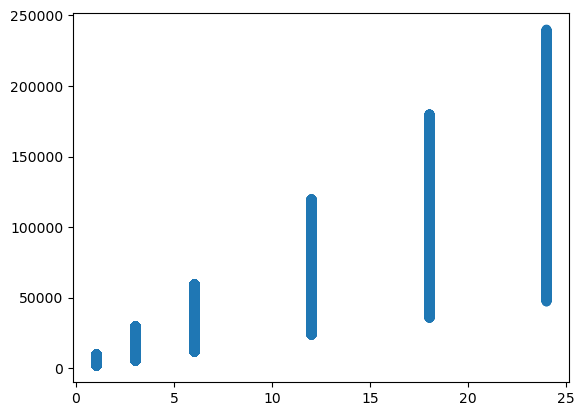

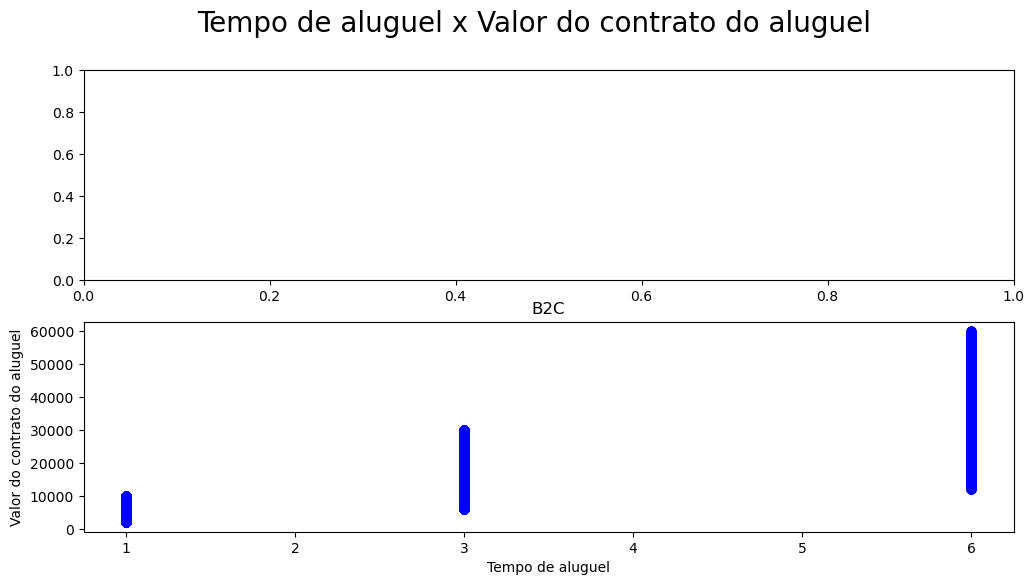

In [503]:
#Quero plotar dois gráficos, um do lado do outro
plt.scatter(db_alugueis['Tempo de aluguel'], db_alugueis['Valor do contrato do aluguel'])

# Grafico do Tempo de aluguel x Valor do contrato do aluguel, para cliente B2B e B2C
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle('Tempo de aluguel x Valor do contrato do aluguel', fontsize=20)

axs[1].scatter(db_alugueis_b2c['Tempo de aluguel'], db_alugueis_b2c['Valor do contrato do aluguel'], color='blue')
axs[1].set_title('B2C')
axs[1].set_xlabel('Tempo de aluguel')
axs[1].set_ylabel('Valor do contrato do aluguel')
plt.show()


- Cliente B2B só realizam contratos a cima de 1 ano enquanto B2C realizam contratos de 6 meses ou menos.

### Analise da Receita, supondo que os contratos quitados foram pagos no mês em que o alugel foi iniciado

    Aqui nós temos o objetivo de entender a composição da receita, poara entender como ela está andando, além disso queremos entender qual o perfil de cliente que mais gera receita, e se a empresa está conseguindo fidelizar os clientes que mais geram receita.

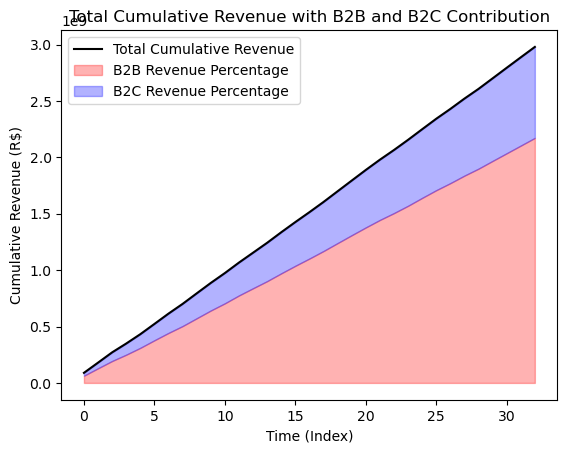

In [504]:
# Analise da receita basica total acumulativa no tempo, desde o começo da empresa, e explorar a porcentagem de receita de cada tipo de cliente
# Plotando o gráfico da Receita cumulativa total ao longo do tempo, analisando a receita mensal, e a porcentagem de receita de cada tipo de cliente
# A coluna valor do contrato, é o valor final fechado, já incluindo desconto e tempo de aluguel
# Plotando o gráfico da Receita cumulativa total ao longo do tempo (um gráfico em baixo do outro)
# Analisando a porcentagem de receita de cada tipo de cliente


# Step 1: Extract month and year from 'Data de início do aluguel'
db_alugueis['Mes'] = db_alugueis['Data de início do aluguel'].dt.month
db_alugueis['Ano'] = db_alugueis['Data de início do aluguel'].dt.year

# Step 2: Filter out rentals that were cancelled
db_alugueis_filtered = db_alugueis[(db_alugueis['Contrato cancelado antes do prazo'] != 'sim') & (db_alugueis['Estado de pagamento'] != 'pendente')]

# Step 3: Group by year, month, and customer type, then calculate total revenue for each group
monthly_revenue = db_alugueis_filtered.groupby(['Mes', 'Ano', 'Tipo do cliente'])['Valor do contrato do aluguel'].sum().reset_index()

# Step 4: Create two separate DataFrames for B2B and B2C
monthly_revenue_b2b = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2b'].copy()
monthly_revenue_b2c = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2c'].copy()

# Step 5: Calculate cumulative revenue for B2B and B2C clients
monthly_revenue_b2b['Cumulative_B2B'] = monthly_revenue_b2b['Valor do contrato do aluguel'].cumsum()
monthly_revenue_b2c['Cumulative_B2C'] = monthly_revenue_b2c['Valor do contrato do aluguel'].cumsum()

# Step 6: Merge the two DataFrames (B2B and B2C) on Year and Month, fill missing values with 0
merged_revenue = pd.merge(monthly_revenue_b2b[['Ano', 'Mes', 'Cumulative_B2B']],
                          monthly_revenue_b2c[['Ano', 'Mes', 'Cumulative_B2C']],
                          on=['Ano', 'Mes'], how='outer').fillna(0)

# Step 7: Calculate the total cumulative revenue and percentage contributions for each type
merged_revenue['Total_Cumulative'] = merged_revenue['Cumulative_B2B'] + merged_revenue['Cumulative_B2C']
merged_revenue['Percentage_B2B'] = (merged_revenue['Cumulative_B2B'] / merged_revenue['Total_Cumulative']) * 100
merged_revenue['Percentage_B2C'] = (merged_revenue['Cumulative_B2C'] / merged_revenue['Total_Cumulative']) * 100

# Plot total cumulative revenue
plt.plot(merged_revenue['Total_Cumulative'], label='Total Cumulative Revenue', color='black')

# Shade the area for B2B and B2C percentages
plt.fill_between(range(len(merged_revenue)), 0, merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 color='red', alpha=0.3, label='B2B Revenue Percentage')
plt.fill_between(range(len(merged_revenue)), 
                 merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 merged_revenue['Total_Cumulative'], color='blue', alpha=0.3, label='B2C Revenue Percentage')

plt.title('Total Cumulative Revenue with B2B and B2C Contribution')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Revenue (R$)')
plt.legend()
plt.show()


- Nota-se que a maior parte da Receita de origina de contratos de clientes do tipo B2B, entretanto a maior parte dos contratos são de clientes do tipo B2C, o que indica que os contratos de B2B são mais valiosos.

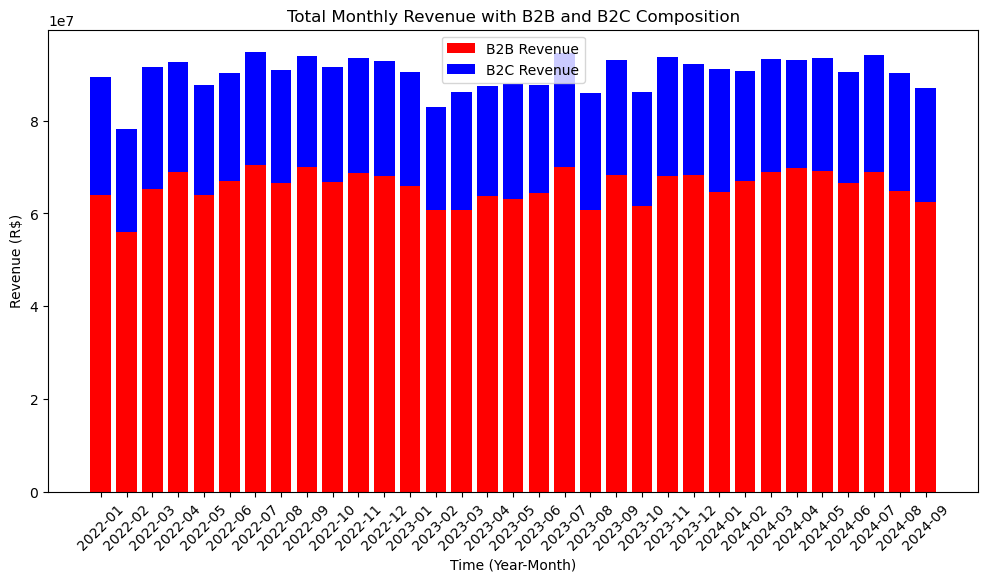

In [505]:
# Agora vamos analisar a receita mensal durante a vida da empresa, entendendo a composição da receita de cada tipo de cliente

# Step 3: Pivot the data to have B2B and B2C revenues as separate columns
pivot_revenue = monthly_revenue.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Valor do contrato do aluguel', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_revenue['Year_Month'] = pivot_revenue.index.get_level_values('Ano').astype(str) + '-' + pivot_revenue.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly revenue
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2b'], label='B2B Revenue', color='red')
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2c'], bottom=pivot_revenue['b2b'], label='B2C Revenue', color='blue')

plt.title('Total Monthly Revenue with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


- Percebe-se que a maior fonte de receita é oriunda de contratos B2B, que são mais longos e valem mais, agora vamos analisar a demanda para ver como estão distribuidos

### Analise da demanda, Vamos entender quantos carros são alugados por mês por cada perfil de cliente

    Aqui queremos realizar uma conexão com a ánalise do faturamento, Queremos entender o ticket médio de clientes B2B e B2C, e entender se a empresa está conseguindo fidelizar os clientes que mais geram receita.
    Além disso, queremos entneder como a empresa está gerindo a frota, como os contratos estão sendo distribuidos, e se a empresa está conseguindo atender a demanda, e ao mesmo tempo e ela está com um estoque muito alto, o que pode ser um problema, pois estara perdendo muito poder de barganha com os clientes B2B, que são contratos mais longos, que caso não sejam renovados, podem gerar um grande prejuizo, especialmente se não existir uma demanda de clientes B2C para suprir.

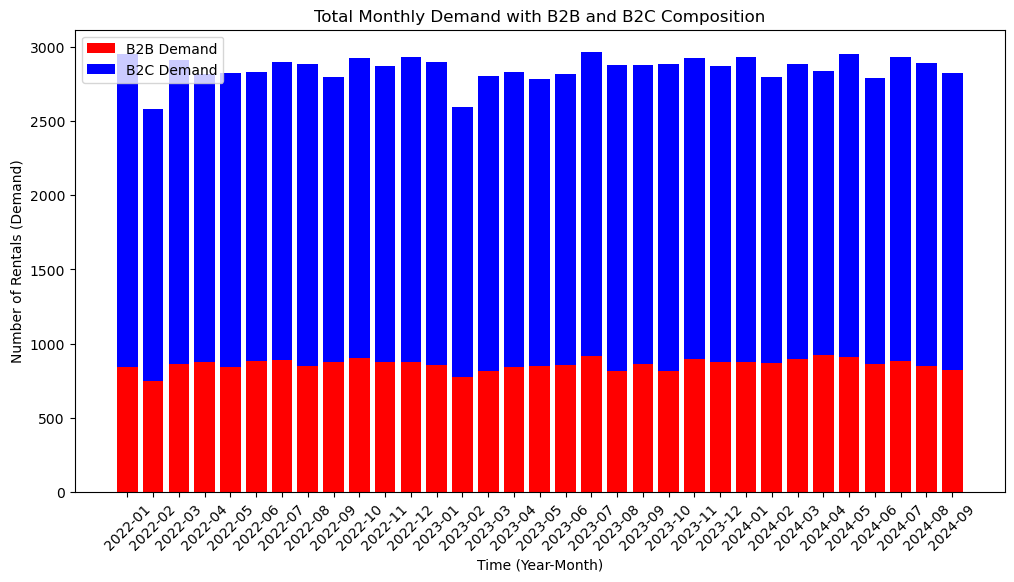

In [506]:
# Step 1: Filter out rentals where the payment is pending and rentals that were cancelled
db_alugueis_filtered = db_alugueis[db_alugueis['Contrato cancelado antes do prazo'] != 'sim']

# Step 2: Group the data by 'Year', 'Month', and 'Tipo do cliente' and count the number of rentals (demand)
monthly_demand = db_alugueis_filtered.groupby(['Ano', 'Mes', 'Tipo do cliente']).size().reset_index(name='Demand')

# Step 3: Pivot the data to have B2B and B2C demand as separate columns
pivot_demand = monthly_demand.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Demand', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_demand['Year_Month'] = pivot_demand.index.get_level_values('Ano').astype(str) + '-' + pivot_demand.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly demand
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C demand as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2b'], label='B2B Demand', color='red')
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2c'], bottom=pivot_demand['b2b'], label='B2C Demand', color='blue')

plt.title('Total Monthly Demand with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Rentals (Demand)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


#### Agora iremos relizar um modelo de previsão da demanda para o próximo ano

Será utilizado o modelo do facebook Prophet, que é um modelo de previsão de séries temporais, utilizado para prever séries temporais com sazonalidade e com tendência.

In [508]:
from prophet import Prophet

# Step 1: Prepare the data (aggregate demand by month for both B2B and B2C)
db_alugueis_filtered = db_alugueis[
    (db_alugueis['Contrato cancelado antes do prazo'] != 'sim')
]

# Aggregate demand by month (count the rentals per month)
monthly_demand = db_alugueis_filtered.groupby(['Ano', 'Mes']).size().reset_index(name='Demand')

# Create a 'ds' column (date format) for Prophet and a 'y' column (demand)
monthly_demand['ds'] = pd.to_datetime(monthly_demand['Ano'].astype(str) + '-' + monthly_demand['Mes'].astype(str) + '-01')
monthly_demand['y'] = monthly_demand['Demand']

# Step 2: Train the Prophet model on historical demand data
model = Prophet()
model.fit(monthly_demand[['ds', 'y']])

# Step 3: Forecast the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast next 12 months
forecast = model.predict(future)

# Step 4: Visualize the forecasted demand along with historical demand
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title('Forecasted Demand for the Next Year')
plt.xlabel('Date')
plt.ylabel('Demand (Number of Rentals)')
plt.show()





AttributeError: 'Prophet' object has no attribute 'stan_backend'